# 第十二章 计算性能

## 12.1 编译器和解释器

### 练习12.1.1

回顾前几章中感兴趣的模型，能提高它们的计算性能吗？

**解答：**


&emsp;&emsp;我们可以使用 `torchscript` 加速第七章的卷积神经网络，同样基于教程中的 `Benchmark` 类进行计时

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
#@save
class Benchmark:
    """用于测量运行时间"""
    def __init__(self, description='Done'):
        self.description = description

    def __enter__(self):
        self.timer = d2l.Timer()
        return self

    def __exit__(self, *args):
        print(f'{self.description}: {self.timer.stop():.4f} sec')

In [3]:
'''第七章的卷积神经网络'''
net = nn.Sequential(
    # 这里使用一个11*11的更大窗口来捕捉对象。
    # 同时，步幅为4，以减少输出的高度和宽度。
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
    nn.Linear(4096, 10))

In [4]:
'''测试'''
X = torch.randn(1, 1, 224, 224)

with Benchmark('无torchscript'):
    for i in range(1000): net(X)
    
net = torch.jit.script(net)
with Benchmark('有torchscript'):
    for i in range(1000): net(X)


无torchscript: 4.9658 sec
有torchscript: 4.7568 sec


## 12.2 异步计算

### 练习12.2.1

在CPU上，对本节中相同的矩阵乘法操作进行基准测试，仍然可以通过后端观察异步吗？

**解答**

通过将设备切换为 CPU，并使用 print 来进行同步（torch.cuda.synchronize()不能对 CPU 进行同步），结果显示使用同步的计算速度并不远高于不使用同步的情况，证明在 CPU 上，没有进行异步计算

In [5]:
import os
import subprocess
import numpy
import torch
from torch import nn
from d2l import torch as d2l

In [9]:
# 使用 CPU 运算
device = "cpu"
a = torch.randn(size=(1000, 1000), device=device)
b = torch.mm(a, a)

with d2l.Benchmark('numpy'):
    for _ in range(10):
        a = numpy.random.normal(size=(1000, 1000))
        b = numpy.dot(a, a)

with d2l.Benchmark('torch'):
    for _ in range(10):
        a = torch.randn(size=(1000, 1000), device=device)
        b = torch.mm(a, a)

with d2l.Benchmark("torch_with_synchronize"):
    for _ in range(10):
        a = torch.randn(size=(1000, 1000), device=device)
        b = torch.mm(a, a)
    print("******************")
    print(b)
    print("******************")

numpy: 0.3352 sec
torch: 0.1344 sec
******************
tensor([[ 43.9199,  -2.6756,  28.1922,  ...,  41.0129,  -9.9432, -34.8527],
        [ 65.3284,  15.3552, -28.0522,  ..., -21.0766,  11.2336,  -1.8195],
        [ 18.2163,  19.2665, -31.8301,  ..., -13.7387, -31.0338, -50.1213],
        ...,
        [-32.6305,  28.6716, -33.5636,  ...,   8.7565,  12.4115, -32.8958],
        [ -0.5626,  -2.3501, -44.2941,  ...,   0.1105,  12.7275,  10.0951],
        [ 23.2528, -14.3513,  44.7984,  ...,  40.3068,  -7.1278, -33.6611]])
******************
torch_with_synchronize: 0.1037 sec


## 12.3 自动并行

### 练习12.3.1

在本节定义的run函数中执行了八个操作，并且操作之间没有依赖关系。设计一个实验，看看深度学习框架是否会自动地并行地执行它们。

**解答**

定义两个函数，每个函数执行8次原run函数的执行内容，但run_synchronize在每次执行之后对GPU进行同步，而run函数不进行同步，经过实验比较，run_synchronize函数执行时间并不远高于run函数，因此判断并不会自动并行执行同一函数中没有依赖关系的若干个操作

In [2]:
import torch
from d2l import torch as d2l

In [3]:
def run(x, device):
    # 不进行同步的函数
    for i in range(8):
        ans = [x.mm(x) for _ in range(10)]
    # 在最后执行8次同步以消除同步操作本身的时间影响
    for i in range(8):
        torch.cuda.synchronize(device)
    return ans

In [5]:
def run_synchronize(x, device):
    # 进行同步的函数
    for i in range(8):
        ans = [x.mm(x) for _ in range(10)]
        torch.cuda.synchronize(device)
    return ans

In [6]:
devices = d2l.try_all_gpus()

x_gpu = torch.rand(size=(4000, 4000), device=devices[0])

run(x_gpu, devices[0])
run_synchronize(x_gpu, devices[0])  # 预热设备
torch.cuda.synchronize(devices[0])

with d2l.Benchmark('无同步'):
    run(x_gpu, devices[0])
    

with d2l.Benchmark('同步'):
    run_synchronize(x_gpu, devices[0])

无同步: 0.7516 sec
同步: 0.7537 sec


### 练习12.3.2


当单个操作符的工作量足够小，即使在单个CPU或GPU上，并行化也会有所帮助。设计一个实验来验证这一点。

### 练习12.3.3

设计一个实验，在CPU和GPU这两种设备上使用并行计算和通信。

**解答**

我们以矩阵乘法为例，分别在 CPU 上通过多线程同步进行并行计算和在 GPU 上基于 CUDA 实现并行计算：

CPU：

In [1]:
import numpy as np
import time
import threading

# 实现矩阵乘法
def matrix_multiply_part(A, B, C, start, end):
    for i in range(start, end):
        for j in range(B.shape[1]):
            C[i][j] = np.sum(A[i, :] * B[:, j])

# 多线程并行实现矩阵乘法的计算
def parallel_matrix_multiply(A, B, num_threads=4):

    # 结果矩阵
    C = np.zeros((A.shape[0], B.shape[1]))

    # 总计算量除以线程数为每个线程的计算量
    step = A.shape[0] // num_threads
    threads = []

    # 创建线程并行计算
    for i in range(num_threads):
        start = i * step
        end = start + step if i < num_threads - 1 else A.shape[0]
        thread = threading.Thread(target=matrix_multiply_part, args=(A, B, C, start, end))
        threads.append(thread)
        thread.start()

    # 等待所有线程计算完成
    for thread in threads:
        thread.join()

    return C

# Example usage
A = np.random.rand(1000, 1000)
B = np.random.rand(1000, 1000)

start_time = time.time()
result_cpu = parallel_matrix_multiply(A, B)
print("CPU 计算耗时", time.time() - start_time, "s")


CPU 计算耗时 19.03621006011963 s


GPU：

In [1]:
import numpy as np
import time
import numba
from numba import cuda

# Numba 装饰器，将 Python 函数编译为 CUDA 核函数以在 GPU 上运行
@cuda.jit
def matrix_multiply_gpu(A, B, C):
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        temp = 0.0
        for k in range(A.shape[1]):
            temp += A[row, k] * B[k, col]
        C[row, col] = temp

# GPU 上的矩阵乘法
def gpu_matrix_multiply(A, B):
    C = np.zeros((A.shape[0], B.shape[1]))
    threads_per_block = (16, 16)
    blocks_per_grid_x = int(np.ceil(A.shape[0] / threads_per_block[0]))
    blocks_per_grid_y = int(np.ceil(B.shape[1] / threads_per_block[1]))
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    matrix_multiply_gpu[blocks_per_grid, threads_per_block](A, B, C)

    return C

# Example usage
A = np.random.rand(1000, 1000)
B = np.random.rand(1000, 1000)

A_global_mem = cuda.to_device(A)
B_global_mem = cuda.to_device(B)
C_global_mem = cuda.device_array((A.shape[0], B.shape[1]))

start_time = time.time()
result_gpu = gpu_matrix_multiply(A_global_mem, B_global_mem)
cuda.synchronize()
print("GPU上耗时", time.time() - start_time, "s")


GPU上耗时 0.38960957527160645 s


/root/autodl-tmp/env/d2l/lib/python3.9/site-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


可见，同样是并行计算，GPU 具有更高的效率。

### 练习12.3.4

使用诸如NVIDIA的Nsight之类的调试器来验证代码是否有效。

**解答**

Nsight 是一套专用于 CUDA 上的代码调试工具，以下是 ChatGPT 给出的使用指南：

NVIDIA的Nsight是一套强大的开发工具套件，用于CUDA和其他GPU编程。Nsight可以帮助您分析、优化和调试CUDA代码。以下是使用Nsight进行CUDA代码验证和调试的一般步骤：

1. **安装Nsight**：
   首先，确保您已经安装了适用于您的平台的NVIDIA Nsight。您可以从NVIDIA官方网站下载并安装Nsight工具。

2. **将代码与Nsight集成**：
   在您的开发环境中，将代码与Nsight集成，以便能够使用其功能。这通常包括配置IDE（例如Visual Studio）以与Nsight一起使用。

3. **打开项目**：
   打开您的CUDA项目或程序。

4. **配置Nsight启动选项**：
   在Nsight中配置启动选项，以便指定程序的启动参数、输入等信息。这将帮助您在Nsight中调试CUDA代码。

5. **设置断点**：
   根据需要，在代码中设置断点，以便在调试过程中停止程序执行并检查状态。

6. **启动调试会话**：
   在Nsight中启动调试会话，允许您逐步执行代码、检查变量和观察程序的行为。

7. **观察程序状态**：
   使用Nsight的调试功能，观察程序的状态、变量值、内存使用等。您可以逐步执行代码，逐行检查程序执行情况。

8. **分析性能**：
   使用Nsight还可以分析CUDA程序的性能，识别瓶颈，并优化代码以提高性能。

9. **调试核函数**：
   可以在Nsight中直接调试CUDA核函数。Nsight允许您在CUDA核函数中设置断点并逐步执行。

这些步骤可以让您充分利用Nsight来验证和调试您的CUDA代码。请注意，确保您的CUDA代码已经正确配置并与GPU兼容。

### 练习12.3.5

设计并实验具有更加复杂的数据依赖关系的计算任务，以查看是否可以在提高性能的同时获得正确的结果。

## 12.4 硬件

### 练习12.4.1 

编写C语言来测试访问对齐的内存和未对齐的内存之间的速度是否有任何差异。（提示：小心缓存影响。）

**解答：**

&emsp;&emsp;编写如下 C 语言程序。首先，定义了一个对齐的结构体 `AlignedStruct` 和一个未对齐的结构体 `UnalignedStruct`。然后，我们分别编写了 `testAlignedMemory()` 和 `testUnalignedMemory()` 函数来测试访问对齐的内存和未对齐的内存。这两个函数会分别申请一个大小为 `ARRAY_SIZE` 的数组，然后对数组中的元素进行一些操作。最后，我们使用 `clock()` 函数计算执行这些操作所用的时间，并将结果打印出来。


```c
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <string.h>

// 测试时的执行步数
#define ARRAY_SIZE 100000000

// 对齐结构体，并确保大小是缓存行的倍数
typedef struct {
    int a;
    int b;
} AlignedStruct __attribute__((aligned(64)));

// 未对齐结构体
typedef struct {
    int a;
    int b;
} UnalignedStruct;

// 测试对齐结构体的访问时间
void testAlignedMemory() {
    // 分配内存
    void* alignedMemory = malloc(sizeof(AlignedStruct) * ARRAY_SIZE);
    AlignedStruct* alignedArray = (AlignedStruct*)alignedMemory;
    int result = 0;
    // 循环访问
    for (int i = 0; i < ARRAY_SIZE; i++) {
        result += alignedArray[i].a + alignedArray[i].b;
    }
    // 释放内存
    free(alignedArray);
    printf("Result (aligned memory): %d\n", result);
}

// 测试未对齐结构体的访问时间
void testUnalignedMemory() {
    // 分配内存
    void* unalignedMemory = malloc(sizeof(UnalignedStruct) * ARRAY_SIZE);
    UnalignedStruct* unalignedArray = (UnalignedStruct*)unalignedMemory;
    int result = 0;
    // 循环访问
    for (int i = 0; i < ARRAY_SIZE; i++) {
        result += unalignedArray[i].a + unalignedArray[i].b;
    }
    // 释放内存
    free(unalignedMemory);
    printf("Result (unaligned memory): %d\n", result);
}

int main() {
    // 时钟计时
    clock_t start, end;
    double cpu_time_used;

    // 预热操作，消除缓存影响
    testAlignedMemory();
    testUnalignedMemory();

    // 开始时间点
    start = clock();
    // 运行对齐内存操作
    testAlignedMemory();
    // 停止时间点
    end = clock();
    // 计算时间差
    cpu_time_used = ((double) (end - start)) / CLOCKS_PER_SEC;
    printf("Time taken (aligned memory): %f seconds\n", cpu_time_used);

    // 与上面类似，这里计算未对齐
    start = clock();
    testUnalignedMemory();
    end = clock();
    cpu_time_used = ((double) (end - start)) / CLOCKS_PER_SEC;
    printf("Time taken (unaligned memory): %f seconds\n", cpu_time_used);

    return 0;
}


&emsp;&emsp;实验结果如下：
```
Result (aligned memory): 0
Result (unaligned memory): 0
Result (aligned memory): 0
Time taken (aligned memory): 0.173222 seconds
Result (unaligned memory): 0
Time taken (unaligned memory): 0.173581 seconds
```



### 练习12.4.2

测试按顺序访问或按给定步幅访问内存时的速度差异。

**解答：**

&emsp;&emsp;类似的，我们编写 C 代码来测试按顺序访问以及按步幅访问数组元素的速度差异。我们定义了两个函数：`testSequentialAccess()` 和 `testStridedAccess()`。`testSequentialAccess()` 函数按顺序访问数组元素，而 `testStridedAccess()` 函数按给定的步幅访问数组元素。在 `main()` 函数中，我们分别调用这两个函数，并计时它们的执行时间。我们使用 `clock()` 函数来测量CPU时钟周期数，然后计算执行时间。

&emsp;&emsp;注意，按步幅访问的函数的数组长度应是按顺序访问的函数的数组长度的步幅倍，以保证两者访问数组的次数相同。

```c
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

#define ARRAY_SIZE 1000000

// 测试按顺序访问数组元素的函数
void testSequentialAccess() {
    // 分配内存空间用于存储整型数组
    int* array = (int*)malloc(sizeof(int) * ARRAY_SIZE);
    int result = 0;

    // 按顺序访问数组元素并累加
    for (int i = 0; i < ARRAY_SIZE; i++) {
        result += array[i];
    }

    // 释放内存空间
    free(array);

    // 打印结果
    printf("Result (sequential access): %d\n", result);
}

// 测试按给定步幅访问数组元素的函数，与上面类似
// @param stride 给定的步幅
void testStridedAccess(int stride) {
    int* array = (int*)malloc(sizeof(int) * ARRAY_SIZE);
    int result = 0;

    // 按给定步幅访问数组元素，总次数与按顺序访问相同
    for (int i = 0; i < ARRAY_SIZE; i++) {
        result += array[(i * stride) % ARRAY_SIZE];
    }

    free(array);
    printf("Result (strided access with stride %d): %d\n", stride, result);
}

int main() {
    clock_t start, end;
    double cpu_time_used;

    // 测试按顺序访问
    start = clock();
    testSequentialAccess();
    end = clock();
    cpu_time_used = ((double)(end - start)) / CLOCKS_PER_SEC;
    printf("Time taken (sequential access): %f seconds\n", cpu_time_used);

    // 测试按给定步幅访问（示例步幅为2）
    start = clock();
    testStridedAccess(2);
    end = clock();
    cpu_time_used = ((double)(end - start)) / CLOCKS_PER_SEC;
    printf("Time taken (strided access with stride 2): %f seconds\n", cpu_time_used);

    return 0;
}


&emsp;&emsp;上述代码运行结果如下：
```
Result (sequential access):0
Time taken (sequential access):0.003282 seconds
Result (strided access with stride 2):0
Time taken (strided access with stride 2):0.003551 seconds
```

### 练习12.4.3

如何测量CPU上的缓存大小？

**解答：**

&emsp;&emsp;以下回答参考ChatGPT：

&emsp;&emsp;要测量CPU上的缓存大小，可以使用如下方法：

&emsp;&emsp;操作系统命令：在大多数操作系统中，您可以使用一些命令来获取有关CPU缓存的信息。例如，在Windows系统上，您可以使用命令 `wmic cpu get L2CacheSize` , `wmic cpu get L3CacheSize` 来获取L2和L3缓存的大小。在Linux系统上，您可以使用 `lscpu` 命令来获取详细的CPU信息，其中包括缓存大小。

&emsp;&emsp;第三方工具：有一些第三方工具可以提供更详细的CPU缓存信息。例如，CPU-Z是一款广泛使用的工具，可提供有关CPU缓存的详细信息，包括大小、类型和配置。

&emsp;&emsp;编程接口：如果您是开发人员或具备编程知识，您可以使用编程语言提供的接口来获取CPU缓存信息。例如，在C/C++中，可以使用CPUID指令来查询缓存参数。有关具体实现方式，请参考相关编程语言的文档和CPU架构的技术手册。

&emsp;&emsp;无论您选择哪种方法，请注意不同的CPU架构和操作系统可能提供不同的工具和接口来获取缓存大小信息。

&emsp;&emsp;例如,在Linux上使用 `lscpu` 命令得到如下结果：


![](../../images/ch12-4-3-example.png)

### 练习12.4.4


如何在多个内存通道中分配数据以获得最大带宽？如果有许多小的线程，会如何分配？

**解答：**

&emsp;&emsp;应调整内存布局，让数据在内存中按照通道进行分布，使每个通道都包含一部分数据，以保证多个通道同时工作，提高整体带宽利用率。同时，尽量使访问模式连续，以最大程度地利用预取和缓存。避免跨通道的频繁切换和不规则的访问模式。

&emsp;&emsp;如果有多个小的线程，可以将它们均匀地分配到可用的内存通道上。这样可以避免某个通道上的线程过多而导致负载不均衡。可以使用线程绑定或者任务调度策略来实现线程和内存通道的分配。确保线程之间的工作负载平衡，并减少竞争和争用


### 练习12.4.5 

一个企业级硬盘正在以10000转/分的速度旋转。在最坏的情况下，硬盘读取数据所需的最短时间是多少（假设磁头几乎是瞬间移动的）？为什么2.5英寸硬盘在商用服务器上越来越流行（相对于3.5英寸硬盘和5.25英寸硬盘）？

**解答：**

&emsp;&emsp;在最坏情况下，硬盘读取数据的最短时间为寻道时间（即硬盘磁头从当前磁道移动到目标磁道所需的时间）与旋转延迟时间（即等待所需数据旋转到磁头下方的时间）之和。

&emsp;&emsp;由于此处我们假设磁头几乎是瞬间移动的，因此可以假设寻道时间为 $ 0 $，则需要的最短时间为旋转延迟时间。

&emsp;&emsp;在最坏情况下，磁头需要旋转一周，因此需要等待 $ 6000 / 10000 = 6 ms $ 的时间。

&emsp;&emsp;因此在最坏的情况下，硬盘读取数据所需的最短时间为  $6 ms $。



&emsp;&emsp;关于为什么 $ 2.5 $ 英寸硬盘更为流行，以下回答参考ChatGPT：

&emsp;&emsp;尺寸和密度：$ 2.5 $ 英寸硬盘比 $ 3.5 $ 英寸硬盘更小巧，适应了越来越小型化的服务器和存储设备的需求。$ 2.5 $ 英寸硬盘的较小尺寸使得服务器可以容纳更多的硬盘，提高存储密度。

&emsp;&emsp;节能和散热：相对于 $ 3.5 $ 英寸硬盘和 $ 5.25 $ 英寸硬盘，$ 2.5 $ 英寸硬盘通常具有较低的功耗和散热量。这对于大规模的服务器部署和数据中心来说非常重要，可以降低能源消耗和散热要求。

&emsp;&emsp;高性能：尽管 $ 2.5 $ 英寸硬盘的物理尺寸较小，但现代 $ 2.5 $ 英寸硬盘仍然能够提供相当高的性能。它们通常具有较快的转速、更高的数据传输速率和较低的访问时间。这使得它们成为对性能要求较高的商用服务器和存储解决方案的理想选择。

&emsp;&emsp;高可靠性：$ 2.5 $ 英寸硬盘通常采用固态硬盘（SSD）技术，相对于传统的机械硬盘，SSD具有更高的可靠性和抗震性能。这使得 $ 2.5 $ 英寸硬盘在商用服务器环境中更受欢迎，因为服务器需要具备稳定和可靠的数据存储。

&emsp;&emsp;综上所述，$ 2.5 $ 英寸硬盘在商用服务器上越来越流行，是由于其小尺寸、高密度、节能散热、高性能和高可靠性等优势，能够满足现代商用服务器对存储解决方案的需求。

### 练习12.4.6

假设HDD制造商将存储密度从每平方英寸1 Tbit增加到每平方英寸5 Tbit。在一个2.5英寸的硬盘上，多少信息能够存储一个环中？内轨和外轨有区别吗？

**解答：**

&emsp;&emsp;首先将存储密度转换为每平方英寸存储的字节数 (Byte)，由于 $ 1 byte = 8 bit $:

$$ 1 Tbit = 1 * 10^{12} bit = 1.25 * 10^{11} byte $$

$$ 5 Tbit = 5 * 10^{12} bit = 6.25 * 10^{11} byte $$

&emsp;&emsp;接着，我们计算 $ 2.5 $ 英寸硬盘的环面积。一般情况下， $ 2.5 $ 英寸的硬盘内径约为 $ 1.75 $ 英寸，外径约为 $ 2.5 $ 英寸。因此，$ 2.5 $ 英寸硬盘的环面积为：

$$ S = (内径 + 外径) * \pi / 2 = (1.75 + 2.5) * \pi / 2 \approx 5.6915 $$

&emsp;&emsp;因此，该硬盘能够存储的信息为：

$$ 存储容量 = 存储密度 * 存储面积 = 6.25*10^{11} * 5.6915 =  3.5634375 * 10^{12} byte $$

&emsp;&emsp;传统的磁盘驱动器中，内轨和外轨之间的存储密度通常不同。外轨比内轨具有更多的物理空间，因此在相同的物理面积上可以存储更多的数据。这是因为外轨的周长更长，可以容纳更多的扇区。

&emsp;&emsp;由于外轨可以存储更多的数据，它们通常具有更高的数据传输速率。这是因为相同的旋转速度下，外轨可以通过单位时间内更多的扇区来传输数据，因此具有更高的数据传输速率。但是，由于外轨的周长较长，它们通常具有更长的寻道时间。


### 练习12.4.7

从$8$位数据类型到$16$位数据类型，硅片的数量大约增加了四倍，为什么？为什么NVIDIA会在其图灵GPU中添加INT4运算？

**解答：**

&emsp;&emsp;以下回答参考ChatGPT：

&emsp;&emsp;NVIDIA在其图灵GPU中添加INT4（4位整数）运算是为了进一步优化深度学习推断任务的性能。这是通过以下原因和考虑而实现的：

&emsp;&emsp;计算效率：INT4运算使用更短的位宽进行计算，相比于较高精度的浮点运算（如FP16或FP32），可以在保持相对较高准确度的同时，显著提高计算效率。INT4模式下，每个数值仅需要4位来表示，因此可以在相同的时间和功耗内执行更多的计算操作，从而提高整体性能。

&emsp;&emsp;内存带宽优化：由于INT4数据占用的存储空间更小，相较于FP16或FP32，传输INT4数据所需的内存带宽更低。这意味着在数据传输阶段，更多的数据可以被传输，从而减少了数据传输的时间和能耗。

&emsp;&emsp;推理性能：深度学习的推理阶段通常不需要高精度的计算，因为推理任务主要关注模型的准确性而非训练时的精度。通过利用INT4运算，可以在推理阶段实现更高的吞吐量和更快的计算速度，同时不会对推理结果的准确性产生显著影响。

&emsp;&emsp;总的来说，通过添加INT4运算支持，NVIDIA图灵GPU提供了更多的灵活性和选择，以满足不同深度学习推断任务的要求。这种优化可以将性能提升到一个新的水平，并在保持相对较低的计算精度的同时，提供更高的效率和吞吐量。

### 练习12.4.8


在内存中向前读比向后读快多少？该数字在不同的计算机和CPU供应商之间是否有所不同？为什么？编写C代码进行实验。

**解答：**

&emsp;&emsp;在一般情况下，向前读取内存比向后读取内存更快。这是因为计算机内存的组织结构通常是连续的，数据在内存中存储的方式与其在程序中的顺序相匹配。当CPU加载一个内存位置的数据时，它通常会预取相邻位置的数据到缓存中，以便将来可能会使用。这就是所谓的局部性原理。当我们向前读取连续的内存位置时，CPU的预取机制能够有效地预取后续数据，因此读取速度更快。而向后读取则会打破局部性原理，可能导致较低的预取效率，从而降低读取速度。

&emsp;&emsp;然而，需要注意的是，实际的性能差异可能因计算机体系结构和CPU供应商而异。不同的计算机和CPU供应商可能具有不同的缓存架构和预取策略，这可能会对向前读和向后读的性能产生一些微妙的影响。

&emsp;&emsp;我们可以通过下面的C代码示例，用于测量向前读和向后读的性能差异：

```c
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

#define ARRAY_SIZE 1000000

int main() {
    int* array = (int*)malloc(sizeof(int) * ARRAY_SIZE);
    int i;
    
    // 初始化数组
    for (i = 0; i < ARRAY_SIZE; i++) {
        array[i] = i;
    }
    
    clock_t start, end;
    double cpu_time_used;
    
    // 预热
    // 向前读取
    for (i = 0; i < ARRAY_SIZE; i++) {
        int value = array[i];
    }
    
    // 向后读取
    for (i = ARRAY_SIZE - 1; i >= 0; i--) {
        int value = array[i];
    }


    // 向前读取
    start = clock();
    for (i = 0; i < ARRAY_SIZE; i++) {
        int value = array[i];
    }
    end = clock();
    cpu_time_used = ((double) (end - start)) / CLOCKS_PER_SEC;
    printf("向前读取耗时: %f 秒\n", cpu_time_used);
    
    // 向后读取
    start = clock();
    for (i = ARRAY_SIZE - 1; i >= 0; i--) {
        int value = array[i];
    }
    end = clock();
    cpu_time_used = ((double) (end - start)) / CLOCKS_PER_SEC;
    printf("向后读取耗时: %f 秒\n", cpu_time_used);
    
    free(array);
    
    return 0;
}
```

&emsp;&emsp;运行结果如下：
```
向前读取耗时：0.002576秒
向后读取耗时：0.802589秒
```

### 练习12.4.9

磁盘的缓存大小能否测量？典型的硬盘是多少？固态驱动器需要缓存吗？

**解答：**

&emsp;&emsp;以下回答参考ChatGPT：

&emsp;&emsp;磁盘的缓存大小通常是由磁盘控制器或磁盘驱动器自身决定的，并且通常无法直接测量。缓存是用于暂存读取和写入磁盘的数据的快速存储区域，旨在提高磁盘访问性能。

&emsp;&emsp;对于典型的机械硬盘（HDD），它通常具有一个较小的缓存，一般在8MB至256MB之间。然而，随着技术的进步，一些高性能的机械硬盘或企业级硬盘可能具有更大的缓存。

&emsp;&emsp;固态驱动器（SSD）的缓存机制与机械硬盘有所不同。SSD内部通常包含一个称为闪存转换层（FTL）的控制器，它负责管理闪存芯片的读写操作。这些控制器通常使用内部DRAM作为缓存，用于加速读取和写入操作。缓存的大小在固态驱动器上可能会有所变化，典型的SSD缓存大小通常在128MB至2GB之间。

&emsp;&emsp;需要注意的是，某些高端企业级固态驱动器（例如服务器级别的SSD）可能具有更大的缓存以实现更高的性能。

&emsp;&emsp;总的来说，无论是机械硬盘还是固态驱动器，缓存都可以提高磁盘访问速度和性能。但是，对于固态驱动器而言，由于其本身的快速访问速度，缓存的重要性相对较小。固态驱动器的主要优势在于其闪存芯片的快速随机读写性能，因此对于固态驱动器来说，较大的缓存并不是绝对必需的。然而，缓存仍然可以在某些读取或写入模式下提供一些性能优势。

### 练习12.4.10

测量通过以太网发送消息时的数据包开销。查找UDP和TCP/IP连接之间的差异。

**解答：**

&emsp;&emsp;可以使用网络抓包工具（例如Wireshark）来捕获数据包，并分析捕获的数据包以了解开销。同时Wireshark可以解析相关的包内容，例如在UDP下可以看到全部信息。

&emsp;&emsp;UDP是是一种无连接的协议，而TCP是一种面向连接的协议。TCP最著名的建立连接是通过“三次挥手”，断开连接通过“四次挥手”。

### 练习12.4.11

直接内存访问允许CPU以外的设备直接向内存写入（和读取）。为什么要这样设计？

**解答：**

&emsp;&emsp;主要有以下几个优势：

&emsp;&emsp; 1. 提高性能：使用DMA可以大大提高数据传输速度和系统性能。传统上，如果设备要将数据传输到内存或从内存中读取数据，需要通过CPU进行数据的复制和传输。这会占用CPU的时间和计算资源。而使用DMA，设备可以直接与内存进行数据交换，无需CPU介入，从而减少了CPU的负担，并提高了数据传输速度。

&emsp;&emsp; 2. 减少延迟：DMA允许设备直接与内存进行数据传输，避免了数据的额外复制和缓冲区操作。这减少了数据传输的延迟，提高了系统的响应速度。特别是在需要高速数据传输的场景下（例如视频流、网络数据传输等），DMA可以显著降低延迟，提供更加实时的数据处理。

&emsp;&emsp; 3. 降低CPU占用率：通过允许设备直接访问内存，DMA可以减少CPU的干预，使CPU能够更专注于执行其他任务。这对于需要处理大量数据传输的场景尤为重要。CPU可以在设备执行DMA传输时执行其他计算任务，提高系统的并发性和整体效率。

### 练习12.4.12

看看Turing T4GPU的性能数字。为什么从FP16到INT8和INT4的性能只翻倍？

**解答：**

&emsp;&emsp;以下是 Turing T4 的性能指标[<sup>1</sup>](#refer-anchor)：

![](../../images/ch12-4-12-T4.png)

&emsp;&emsp;从 FP16 到 INT8 到 INT4 性能翻倍的原因是，数据占用位数减半了。

<div id="#refer-anchor"></div>

[1] [NVIDIA T4 Homepage](https://www.nvidia.cn/data-center/tesla-t4/)

### 练习12.4.13

一个网络包从旧金山到阿姆斯特丹的往返旅行需要多长时间？提示：可以假设距离为10000公里。

**解答：**

&emsp;&emsp;假设网络的带宽为 $ 100Mbps $（兆比特每秒）， 则 $ 10000 $ 公里转换的比特数为：

$$ num_{bit} = 10000 * 1000 * 8 = 8 * 10^{9} bit $$

&emsp;&emsp;则网络包的单程时间为：

$$ time = num_{bit} / bandwidth = 8 * 10^9 / (1 * 10^8) = 80 s $$

&emsp;&emsp;则网络包的往返时间为：

$$ time_{whole} = time * 2 = 160 s $$

&emsp;&emsp;因此，一个网络包从旧金山到阿姆斯特丹的往返旅行时间为 $ 160 $ 秒。

## 12.5 多 GPU 训练

### 练习12.5.1

在 k 个GPU上进行训练时，将批量大小从 b 更改为 k * b，即按GPU的数量进行扩展。

**解答**

在2个 GPU 上进行训练，将批次大小从256调整为512，直接在 train 函数中传递 batch_size=512 即可。根据数据并行理论，批次大小调整之后，准确率不变（动态），训练所需时间减少。

In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
'''教程代码'''
# 初始化模型参数
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

# 定义模型
def lenet(X, params):
    # print("X:", X.device)
    # print("param:", params[0].device)
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat

# 交叉熵损失函数
loss = nn.CrossEntropyLoss(reduction='none')

def get_params(params, device):
    new_params = [p.to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params

def allreduce(data):
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device)
    for i in range(1, len(data)):
        data[i][:] = data[0].to(data[i].device)

#@save
def split_batch(X, y, devices):
    """将X和y拆分到多个设备上"""
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X, devices),
            nn.parallel.scatter(y, devices))

def train_batch(X, y, device_params, devices, lr):
    X_shards, y_shards = split_batch(X, y, devices)
    # 在每个GPU上分别计算损失
    ls = [loss(lenet(X_shard, device_W), y_shard).sum()
          for X_shard, y_shard, device_W in zip(
              X_shards, y_shards, device_params)]
    for l in ls:  # 反向传播在每个GPU上分别执行
        l.backward()
    # 将每个GPU的所有梯度相加，并将其广播到所有GPU
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce(
                [device_params[c][i].grad for c in range(len(devices))])
    # 在每个GPU上分别更新模型参数
    for param in device_params:
        d2l.sgd(param, lr, X.shape[0]) # 在这里，我们使用全尺寸的小批量

def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    # 将模型参数复制到num_gpus个GPU
    device_params = [get_params(params, d) for d in devices]
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            # 为单个小批量执行多GPU训练
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()
        timer.stop()
        # 在GPU0上评估模型
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
        
    print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，'
          f'在{str(devices)}')
    return animator.Y[0][-1]



测试精度：0.84，3.3秒/轮，在[device(type='cuda', index=0), device(type='cuda', index=1)]


0.8366

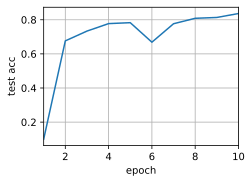

In [3]:
# 对照组——批次为256的效果
train(num_gpus=2, batch_size=256, lr=0.2)

测试精度：0.79，2.2秒/轮，在[device(type='cuda', index=0), device(type='cuda', index=1)]


0.7927

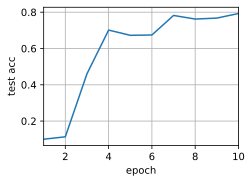

In [4]:
# 实验组——批次为512的效果
train(num_gpus=2, batch_size=512, lr=0.2)

### 练习12.5.2

比较不同学习率时模型的精确度，随着GPU数量的增加学习率应该如何扩展？

**解答**

我们设置了单卡（批次大小256）、双卡（批次大小512）两个组别，分别在学习率 

（0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6）

等多个环境下进行训练与测试，测试代码及结果如下：

测试精度：0.77，2.2秒/轮，在[device(type='cuda', index=0), device(type='cuda', index=1)]


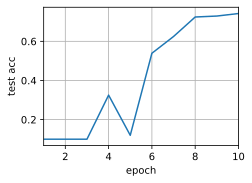

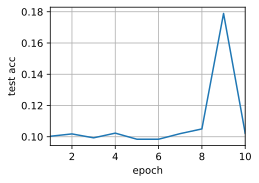

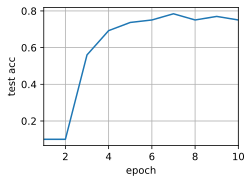

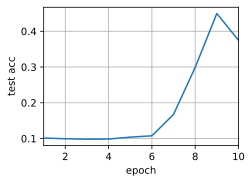

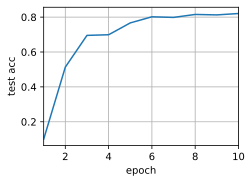

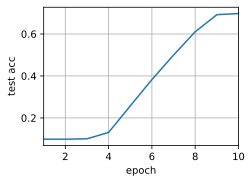

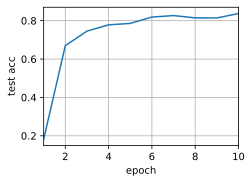

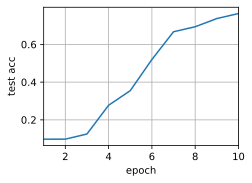

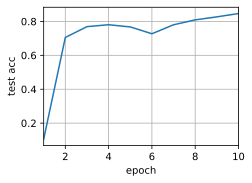

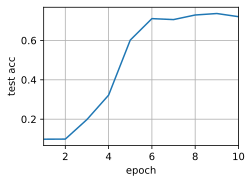

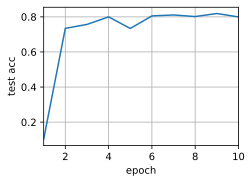

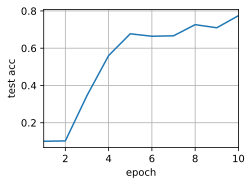

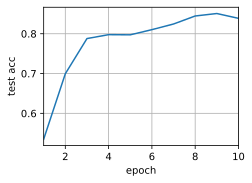

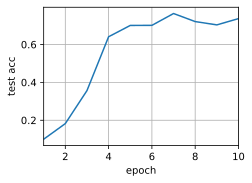

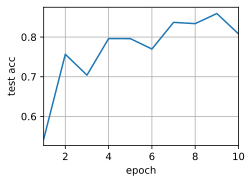

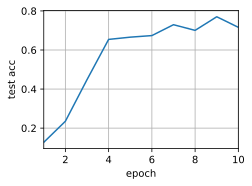

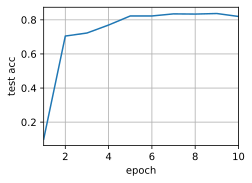

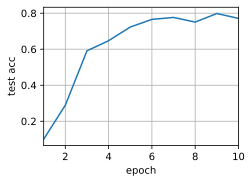

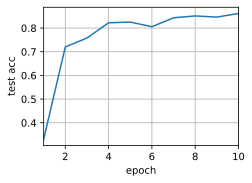

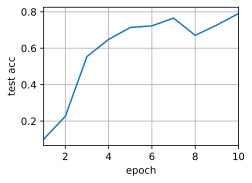

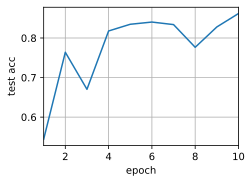

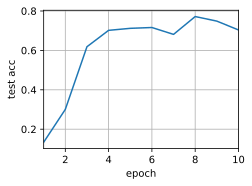

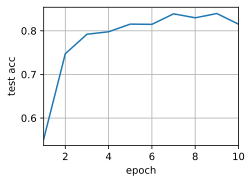

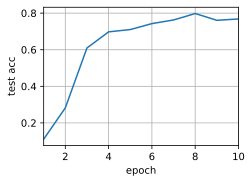

In [13]:
# 对比实验

lr_lst = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6]

accs = []

for lr in lr_lst:
    this_acc = {}
    # 单 GPU
    this_acc["single"] = train(num_gpus=1, batch_size=256, lr=lr)
    # 双 GPU
    this_acc["multi"] = train(num_gpus=2, batch_size=512, lr=lr)
    this_acc["lr"] = lr
    accs.append(this_acc)




In [14]:
# 实验结果

accs

[{'single': 0.7422, 'multi': 0.1022, 'lr': 0.05},
 {'single': 0.7508, 'multi': 0.3748, 'lr': 0.1},
 {'single': 0.8208, 'multi': 0.6975, 'lr': 0.15},
 {'single': 0.8374, 'multi': 0.7638, 'lr': 0.2},
 {'single': 0.8467, 'multi': 0.7205, 'lr': 0.25},
 {'single': 0.7995, 'multi': 0.7748, 'lr': 0.3},
 {'single': 0.8387, 'multi': 0.7365, 'lr': 0.35},
 {'single': 0.8081, 'multi': 0.7161, 'lr': 0.4},
 {'single': 0.8198, 'multi': 0.7712, 'lr': 0.45},
 {'single': 0.8616, 'multi': 0.7905, 'lr': 0.5},
 {'single': 0.862, 'multi': 0.7038, 'lr': 0.55},
 {'single': 0.8152, 'multi': 0.7681, 'lr': 0.6}]

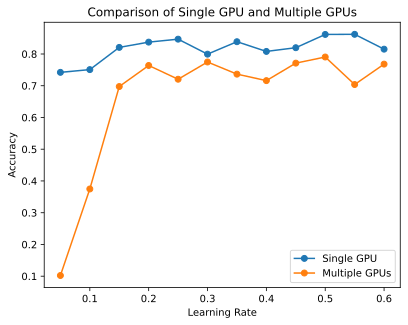

In [15]:
# 绘制结果图

import matplotlib.pyplot as plt

# 提取数据
lr_values = [item['lr'] for item in accs]
single_values = [item['single'] for item in accs]
multi_values = [item['multi'] for item in accs]

# 绘制折线图
plt.plot(lr_values, single_values, marker='o', label='Single GPU')
plt.plot(lr_values, multi_values, marker='o', label='Multiple GPUs')

# 设置图表标题和轴标签
plt.title('Comparison of Single GPU and Multiple GPUs')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')

# 添加图例
plt.legend()

# 展示图表
plt.show()

实验证明，数据并行的情况下，当运行 GPU 数量扩大 k 倍时，学习率也应该相应扩大 k 倍左右

### 练习12.5.3 

实现一个更高效的 allreduce 函数用于在不同的 GPU 上聚合不同的参数？为什么这样的效率更高？

**解答**

原教程中的 allreduce 函数通过简单的将各个 GPU 上的参数相加再广播实现参数的聚合，我们可以采用基于树的聚合算法，来减少通信次数，提高并行计算效率。

以下函数使用了二叉树归约算法，通过在每一轮迭代中将两个张量相加，并将结果存储在第一个张量中，逐步将所有张量归约到一个张量上，从而减少了通信次数。原始的 allreduce 函数中，每个张量都需要与其他所有张量进行通信，总共需要进行 n-1 次通信，其中 n 是 GPU 的数量。而改进版的算法中，每个张量只需要进行 log2(n) 次通信。这是因为在归约阶段，每轮迭代都将一半的张量归约到前一半的张量上，这样每轮迭代后剩余的张量数量减半，直到最后只有一个张量。在广播阶段，只需要将第一个张量广播给其他张量。

注意：在双卡环境下，此函数没有明显的效率提高；卡数越多，效率提高越显著

In [7]:
import torch

def allreduce(data: list):
    # 获取需通信的进程总数
    world_size = len(data)

    # 将所有张量移动到相同的设备上
    device = data[0].device
    for i in range(1, world_size):
        data[i] = data[i].to(device)

    # 归约阶段
    for i in range(world_size - 1):
        if i % 2 == 0:
            src = i + 1
            dest = i
        else:
            src = i
            dest = i + 1
        torch.cuda.synchronize(device)  # 同步设备上的计算
        data[dest] += data[src]

    # 广播阶段
    for i in range(1, world_size):
        src = 0
        dest = i
        torch.cuda.synchronize(device)  # 同步设备上的计算
        data[dest] = data[src].to(data[dest].device)


In [8]:
# 测试
data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
print('allreduce之前：\n', data[0], '\n', data[1])
allreduce(data)
print('allreduce之后：\n', data[0], '\n', data[1])

allreduce之前：
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]], device='cuda:1')
allreduce之后：
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]], device='cuda:0')


### 练习12.5.4

实现模型在多GPU下测试精度的计算。

**解答**

要实现多 GPU 的测试精度计算，可以基于 split_batch 函数，在测试阶段将每一批数据进行拆分，每个设备上计算分配到的数据的精度，再进行汇总计算最终测试精度。
需要额外实现一个 evaluate_accuracy_gpus 函数

In [9]:
def evaluate_accuracy_gpus(data_iter, devices):
    """Compute the accuracy for a model on a dataset using a GPU.

    Defined in :numref:`sec_lenet`"""
    # 传入参数分别为该该批数据以及模型参数
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            # 切分数据
            X_shards, y_shards = split_batch(X, y, devices)
            metrics = 0
            for X_shard, y_shard, device_W in zip(X_shards, y_shards, devices):
                # 存在部分数据没有与参数对齐，没有对齐的进行一次转移
                if X_shard.device != device_W[0].device:
                    # print("进入传递分支")
                    # print("传递之前X：", X_shard.device)
                    # print("传递之前param:", device_W[0].device)
                    # print("传递之前y：", y_shard.device)
                    X_shard = X_shard.to(device_W[0].device)
                    y_shard = y_shard.to(device_W[0].device)
                    # print("传递之后x：", X_shard.device)
                    # print("传递之后y：", y_shard.device)
                y_pre = lenet(X_shard, device_W)
                metrics += d2l.accuracy(y_pre, y_shard)
            metric.add(metrics, d2l.size(y))
    return metric[0] / metric[1]

In [10]:
# 使用多卡测试精度的 train 函数
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    # 将模型参数复制到num_gpus个GPU
    device_params = [get_params(params, d) for d in devices]
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            # 为单个小批量执行多GPU训练
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()
        timer.stop()
        # 在多卡上测试精度
        animator.add(epoch + 1, (evaluate_accuracy_gpus(
            test_iter, device_params),))
    print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，'
          f'在{str(devices)}')
    return animator.Y[0][-1]

测试精度：0.77，2.2秒/轮，在[device(type='cuda', index=0), device(type='cuda', index=1)]


0.7699

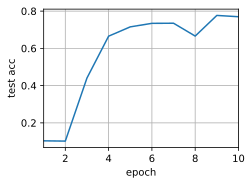

In [11]:
train(num_gpus=2, batch_size=512, lr=0.4)

## 12.6 多 GPU 的简洁实现

### 练习12.6.1

本节使用ResNet-18，请尝试不同的迭代周期数、批量大小和学习率，以及使用更多的GPU进行计算。如果使用16个GPU（例如，在AWS p2.16xlarge实例上）尝试此操作，会发生什么？

**解答：**

&emsp;&emsp;基于教程代码，本节分别对不同的迭代周期数、批次大小、学习率、GPU数量进行实验，记录并比较实验结果。

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

In [5]:
#@save
def resnet18(num_classes, in_channels=1):
    """稍加修改的ResNet-18模型"""
    def resnet_block(in_channels, out_channels, num_residuals,
                     first_block=False):
        blk = []
        for i in range(num_residuals):
            # 判断：是否为ResNet模块的第一个残差块
            if i == 0 and not first_block:
                # 如果是第一个残差块且不是第一个ResNet模块，使用1x1的卷积层来匹配通道数，同时步幅为2，以减小高和宽。
                blk.append(d2l.Residual(out_channels, use_1x1conv=True,
                                        strides=2))
            else:
                blk.append(d2l.Residual(out_channels))
        return nn.Sequential(*blk)

    # 该模型使用了更小的卷积核、步长和填充，而且删除了最大汇聚层
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())
    net.add_module("resnet_block1", resnet_block(64, 64, 2, first_block=True))
    net.add_module("resnet_block2", resnet_block(64, 128, 2))
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2))
    net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1,1)))
    net.add_module("fc", nn.Sequential(nn.Flatten(),
                                       nn.Linear(512, num_classes)))
    
    return net



In [6]:
net = resnet18(10)
# 获取GPU列表
devices = d2l.try_all_gpus()
# 我们将在训练代码实现中初始化网络

&emsp;&emsp;迭代周期数: $ 30 $ epochs

In [8]:
def train(net, num_gpus, batch_size, lr):
    # 通过DataLoader获取和读取数据
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    # 定义训练GPU数量
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    def init_weights(m):
        if type(m) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(m.weight, std=0.01)
    # 初始化网络权重
    net.apply(init_weights)
    # 在多个GPU上设置模型
    net = nn.DataParallel(net, device_ids=devices)
    device = torch.device("cuda:0" )
    net.to(device)
    # 定义优化器
    trainer = torch.optim.SGD(net.parameters(), lr)
    # 定义损失函数
    loss = nn.CrossEntropyLoss()
    # 训练计时与迭代次数
    timer, num_epochs = d2l.Timer(), 30
    # 绘制不同epoch的测试精度
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            # print(X.device)
            # print(net.device_ids)
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(net, test_iter),))
    print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，'
          f'在{str(devices)}')

测试精度：0.93，7.9秒/轮，在[device(type='cuda', index=0), device(type='cuda', index=1)]


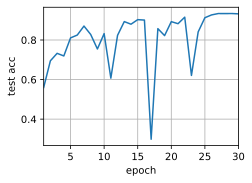

In [9]:
# 实验：30个 epoch
train(net, num_gpus=2, batch_size=512, lr=0.2)

&emsp;&emsp;多种不同的批次大小：$ 128, 256, 512, 1024, 2048 $

In [10]:
# 代码与上类似
def train(net, num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    def init_weights(m):
        if type(m) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)
    # 在多个GPU上设置模型
    net = nn.DataParallel(net, device_ids=devices)
    device = torch.device("cuda:0" )
    net.to(device)
    trainer = torch.optim.SGD(net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    timer, num_epochs = d2l.Timer(), 30
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(net, test_iter),))
    print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，'
          f'在{str(devices)}')
    return animator.Y[0][-1]

测试精度：0.86，7.1秒/轮，在[device(type='cuda', index=0), device(type='cuda', index=1)]


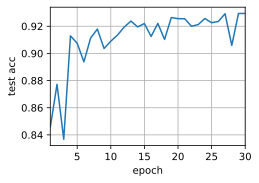

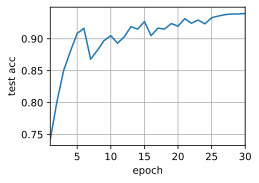

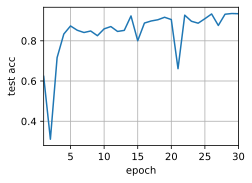

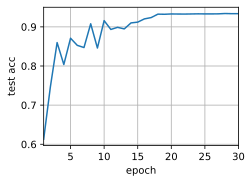

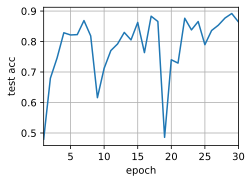

In [11]:
import time
# 测试多种不同的 batch_size
batch_sizes = [128, 256, 512, 1024, 2048]
results = []
for batch_size in batch_sizes:
    start_time = time.time()
    result = train(net, num_gpus=2, batch_size=batch_size, lr=0.2)
    times = time.time() - start_time
    results.append({"acc":result, "time":times, "batch_size":batch_size})
    
    

In [12]:
results

[{'acc': 0.9294, 'time': 866.1086549758911, 'batch_size': 128},
 {'acc': 0.9396, 'time': 434.37915086746216, 'batch_size': 256},
 {'acc': 0.9346, 'time': 277.34259510040283, 'batch_size': 512},
 {'acc': 0.9337, 'time': 251.3746223449707, 'batch_size': 1024},
 {'acc': 0.8642, 'time': 255.2120397090912, 'batch_size': 2048}]

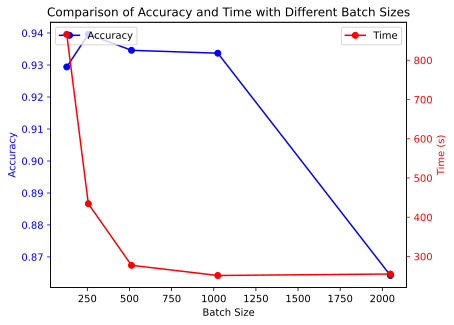

In [13]:
import matplotlib.pyplot as plt

batch_sizes = [d['batch_size'] for d in results]
accuracies = [d['acc'] for d in results]
times = [d['time'] for d in results]

fig, ax1 = plt.subplots()

# 绘制精度曲线
ax1.plot(batch_sizes, accuracies, 'b-o')
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('Accuracy', color='b')
ax1.tick_params('y', colors='b')

# 创建第二个坐标轴，用于绘制时间曲线
ax2 = ax1.twinx()
ax2.plot(batch_sizes, times, 'r-o')
ax2.set_ylabel('Time (s)', color='r')
ax2.tick_params('y', colors='r')

# 添加图例
ax1.legend(['Accuracy'], loc='upper left')
ax2.legend(['Time'], loc='upper right')

# 设置标题和横纵坐标标签
plt.title('Comparison of Accuracy and Time with Different Batch Sizes')
plt.xlabel('Batch Size')

# 显示图形
plt.show()


&emsp;&emsp;测试多种不同学习率：$ 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6 $。

&emsp;&emsp;即从 $ 0.05 $ 到 $ 0.6 $ ，步长为 $ 0.05 $ 。

In [7]:
# 代码与上类似
def train(net, num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    def init_weights(m):
        if type(m) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)
    # 在多个GPU上设置模型
    net = nn.DataParallel(net, device_ids=devices)
    device = torch.device("cuda:0" )
    net.to(device)
    trainer = torch.optim.SGD(net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    timer, num_epochs = d2l.Timer(), 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(net, test_iter),))
    print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，'
          f'在{str(devices)}')
    return animator.Y[0][-1]

测试精度：0.83，7.8秒/轮，在[device(type='cuda', index=0), device(type='cuda', index=1)]


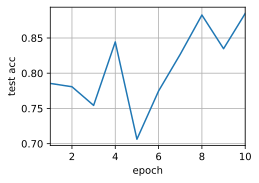

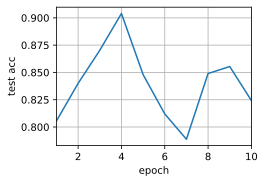

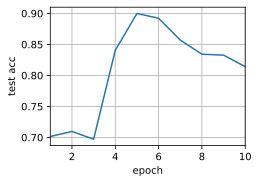

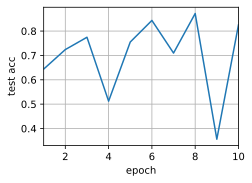

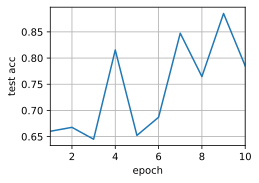

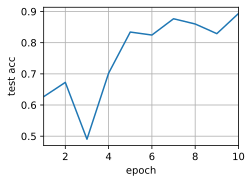

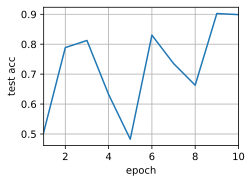

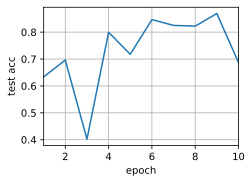

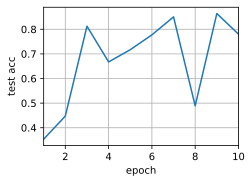

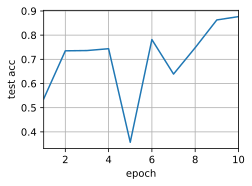

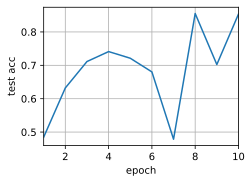

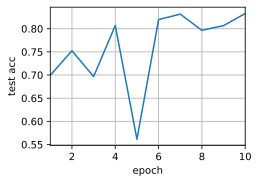

In [5]:
# 设置不同的学习率
lr_lst = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6]

accs = []

for lr in lr_lst:
    this_acc = {}
    this_acc["result"] = train(net, num_gpus=2, batch_size=512, lr=lr)
    this_acc["lr"] = lr
    accs.append(this_acc)

In [6]:
accs

[{'result': 0.8848, 'lr': 0.05},
 {'result': 0.8242, 'lr': 0.1},
 {'result': 0.8141, 'lr': 0.15},
 {'result': 0.8254, 'lr': 0.2},
 {'result': 0.7849, 'lr': 0.25},
 {'result': 0.8934, 'lr': 0.3},
 {'result': 0.8989, 'lr': 0.35},
 {'result': 0.6873, 'lr': 0.4},
 {'result': 0.7801, 'lr': 0.45},
 {'result': 0.8767, 'lr': 0.5},
 {'result': 0.8534, 'lr': 0.55},
 {'result': 0.8329, 'lr': 0.6}]

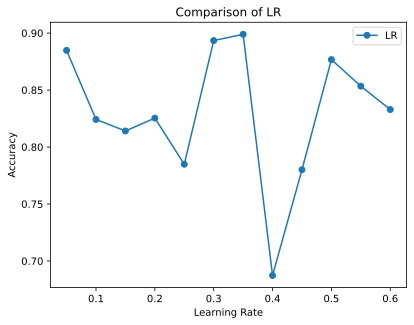

In [7]:
# 绘制结果图

import matplotlib.pyplot as plt

# 提取数据
lr_values = [item['lr'] for item in accs]
multi_values = [item['result'] for item in accs]

# 绘制折线图
plt.plot(lr_values, multi_values, marker='o', label='LR')

# 设置图表标题和轴标签
plt.title('Comparison of LR')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')

# 添加图例
plt.legend()

# 展示图表
plt.show()

&emsp;&emsp;调整GPU数：$ 8 $

测试精度：0.78，4.9秒/轮，在[device(type='cuda', index=0), device(type='cuda', index=1), device(type='cuda', index=2), device(type='cuda', index=3), device(type='cuda', index=4), device(type='cuda', index=5), device(type='cuda', index=6), device(type='cuda', index=7)]


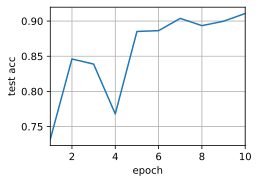

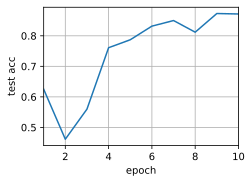

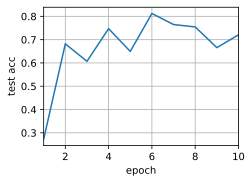

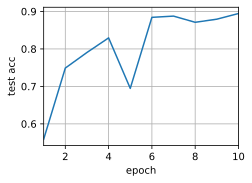

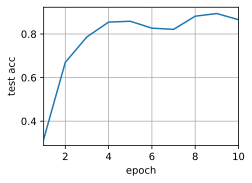

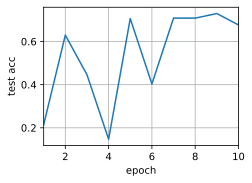

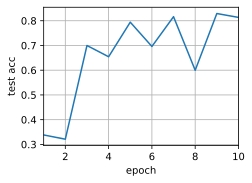

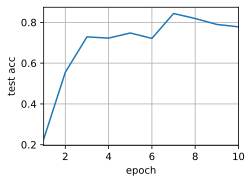

In [7]:
# 最多8张卡，16张实在是租不起了QWQ
import time

accs = []
gpus = range(1, 9)
for gpu in gpus:
    this_acc = {}
    start_time = time.time()
    this_acc["result"] = train(net, num_gpus=gpu, batch_size=256 * gpu, lr=0.4)
    this_acc["gpus"] = gpu
    this_acc["time"] = time.time() - start_time
    accs.append(this_acc)

In [8]:
accs

[{'result': 0.9108, 'gpus': 1, 'time': 118.11584854125977},
 {'result': 0.8715, 'gpus': 2, 'time': 85.94616866111755},
 {'result': 0.7207, 'gpus': 3, 'time': 75.53924202919006},
 {'result': 0.8944, 'gpus': 4, 'time': 69.73074865341187},
 {'result': 0.8657, 'gpus': 5, 'time': 66.9669406414032},
 {'result': 0.6768, 'gpus': 6, 'time': 65.36396265029907},
 {'result': 0.8135, 'gpus': 7, 'time': 63.94503688812256},
 {'result': 0.7781, 'gpus': 8, 'time': 63.32349872589111}]

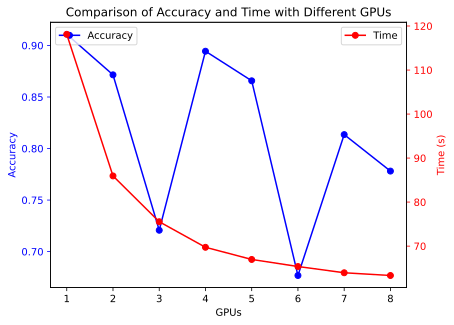

In [10]:
import matplotlib.pyplot as plt

gpus = [d['gpus'] for d in accs]
accuracies = [d['result'] for d in accs]
times = [d['time'] for d in accs]

fig, ax1 = plt.subplots()

# 绘制精度曲线
ax1.plot(gpus, accuracies, 'b-o')
ax1.set_xlabel('GPUs')
ax1.set_ylabel('Accuracy', color='b')
ax1.tick_params('y', colors='b')

# 创建第二个坐标轴，用于绘制时间曲线
ax2 = ax1.twinx()
ax2.plot(gpus, times, 'r-o')
ax2.set_ylabel('Time (s)', color='r')
ax2.tick_params('y', colors='r')

# 添加图例
ax1.legend(['Accuracy'], loc='upper left')
ax2.legend(['Time'], loc='upper right')

# 设置标题和横纵坐标标签
plt.title('Comparison of Accuracy and Time with Different GPUs')
plt.xlabel('GPUs')

# 显示图形
plt.show()


### 练习12.6.2

有时候不同的设备提供了不同的计算能力，我们可以同时使用GPU和CPU，那应该如何分配工作？为什么？

**解答：**

&emsp;&emsp;在同时使用GPU和CPU进行神经网络训练时，可以使用以下策略来分配工作：

&emsp;&emsp;数据预处理和后处理：通常情况下，数据预处理和后处理的计算量相对较小，可以将其分配给CPU来处理。CPU在处理这些任务时通常更有效率，因为它具有更强大的通用计算能力。

&emsp;&emsp;模型训练：将神经网络的前向传播和反向传播过程分配给GPU来处理。GPU在执行大规模矩阵计算和并行计算任务时非常强大，特别适合深度学习模型的训练过程。

&emsp;&emsp;将工作分配给GPU的原因是，GPU具有大量的并行计算单元，能够同时处理多个数据样本和参数更新。这对于深度学习中涉及大量矩阵运算的任务非常重要，因为GPU可以以更高的速度执行这些计算，从而加快模型训练的速度。另一方面，CPU具有更强大的通用计算能力和更低的延迟，适合处理较小规模的计算任务。将数据预处理和后处理任务分配给CPU可以充分利用其高效的通用计算能力，并减轻GPU的负担，从而提高整体的训练效率。

&emsp;&emsp;综上所述，通过将数据预处理和后处理任务分配给CPU，将模型训练任务分配给GPU，可以充分利用不同设备的特点，实现更高效的深度学习模型训练。

## 12.7 参数服务器

### 练习12.7.1 

请尝试进一步提高环同步的性能。（提示：可以双向发送消息。）

**解答：**

&emsp;&emsp;结合双向发送消息可以进一步提高环同步的性能，增加并行性和减少通信开销。双向发送消息允许节点同时发送和接收梯度信息，从而减少同步所需的通信步骤：

&emsp;&emsp; 1. 双向通信结构：可以设计一个双向的通信结构，使得每个节点可以同时向前一个节点和后一个节点发送梯度信息，同时接收这两个节点的梯度信息。

&emsp;&emsp; 2. 并行传递梯度：在环同步的过程中，节点可以同时向前一个节点和后一个节点发送本地梯度，同时接收这两个节点的梯度，这样可以并行传递梯度，提高传递效率。

&emsp;&emsp; 3. 异步处理梯度：节点在接收到梯度后可以异步处理这些梯度，而不必等待所有梯度都接收完毕。这样可以减少等待时间，提高训练的效率。

&emsp;&emsp; 4. 分阶段同步：可以将环同步过程分成多个阶段，在每个阶段内进行双向消息传递和梯度更新。这样可以减少每个阶段内的通信开销，并充分利用双向通信结构。


### 练习12.7.2

在计算仍在进行中，可否允许执行异步通信？它将如何影响性能？

**解答：**

&emsp;&emsp;在计算进行时，可以允许执行异步通信。

&emsp;&emsp;在计算进行时执行异步通信可以使计算与通信同步进行，尤其是通信开销较大时，能较大程度优化性能、减少训练时间。

&emsp;&emsp;然后，执行异步通信也可能导致节点的计算和通信负载不平衡，且异步通信会导致内存使用的增加，从而带来负载与内存的压力。

### 练习12.7.3

怎样处理在长时间运行的计算过程中丢失了一台服务器这种问题？尝试设计一种容错机制来避免重启计算？

**解答：**

&emsp;&emsp;来自 ChatGPT 回答：

&emsp;&emsp;下面是一种容错机制的简要设计：

&emsp;&emsp; 1. 任务切片和检查点：将长时间运行的任务划分成多个小任务或切片。在每个任务完成后，将当前任务的状态进行检查点（Checkpointing）保存。这样可以将任务的进度进行保存，避免丢失整个计算过程。

&emsp;&emsp; 2. 状态监测：定期监测各个服务器的状态。可以通过心跳机制或其他状态监测手段来检测服务器的存活状态。如果某台服务器长时间没有响应，可以认为它丢失了。

&emsp;&emsp; 3. 备份节点：在集群中设置备份节点，当检测到某台服务器丢失时，备份节点可以接管丢失节点的工作。备份节点应该具备与丢失节点相同的计算能力，以确保计算的连续性。

&emsp;&emsp; 4. 状态恢复和继续计算：当发现某台服务器丢失后，可以从最近一次的检查点开始，将任务分配给备份节点进行恢复和继续计算。这样可以避免重启计算，节省计算资源和时间。

&emsp;&emsp; 5. 任务重新分配：将丢失服务器上的任务重新分配给其他服务器，以确保任务能够及时完成。可以根据任务的优先级和进度来决定重新分配的策略。

&emsp;&emsp; 6. 日志和异常处理：在系统中加入详尽的日志记录和异常处理机制，以便及时发现问题并进行处理。记录计算过程中的关键信息，以便排查问题和进行后续的分析。

&emsp;&emsp; 通过以上设计，可以实现在长时间运行的计算过程中丢失服务器时的容错处理，确保计算任务的连续性和高效性。同时，避免了不必要的计算重启，减少了计算资源的浪费。